In [9]:
from kafka import KafkaConsumer
from json import loads
import json
from time import sleep
import pandas as pd
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("C:\\Users\\Gjirafa\\Alberti\\AlbZa\\OpenSource\\ost-sm-change-detection\\streaming")  

from albert.algorithms.page_hinkley import *
from albert.influxdb_creds import *
from albert.algorithms.evaluation_functions import * 
from albert.model.load_model import *
from albert.algorithms.utils import *
from albert.kafka.kafka_topics import *

In [10]:
print(topic_preprocessor)

hai-preprocessed-albert


Page-Hinkley

In [11]:
model = get_model()

In [12]:
class HaiConsumer:
    def __init__(self, topic, bootstrap_servers):
        self.topic = topic
        self.bootstrap_servers = bootstrap_servers
        self.consumer = KafkaConsumer(
            self.topic,
            bootstrap_servers=self.bootstrap_servers,
            auto_offset_reset='earliest',
            enable_auto_commit=True,
            value_deserializer=lambda x: loads(x.decode('utf-8')))

    def consume(self):
        # Initialize Page-Hinkley detector
        page_hinkley = PageHinkley(min_instances=30, delta=0.005, threshold=50, alpha=1-0.0001)

        counter = 0
        # Perform change detection on the test set
        global change_points
        global accuracies
        global whole_df
        global whole_labels
        change_points = []
        accuracies = []
        whole_df = pd.DataFrame()
        whole_labels = pd.Series()
        # write to file
        with influxdb_client.InfluxDBClient(url=url, token=token, org=org) as client:
            write_api = client.write_api(write_options=SYNCHRONOUS)
            for i, message in enumerate(self.consumer):
                change_detection = 0
                false_change_detection = 0
                message = message.value
                print(message)
                # selected_columns = {key: value for key, value in message.items() if key in columns_to_scale_and_monitor}
                df = pd.DataFrame([message])
                x_i, y_i = split_df(df)
                x_i = x_i.iloc[0:1]
                
                whole_df =pd.concat([whole_df,x_i], ignore_index=True)
                whole_labels = pd.concat([whole_labels,y_i], ignore_index=True)

                # Predict using the RandomForest model
                pred = model.predict(x_i)

                # Check for a change point
                if page_hinkley.add_element(pred == int(y_i)):
                    change_detection = 1
                    if int(y_i) == 0:
                        false_change_detection = 1
                    change_points.append(i)
                
                # Calculate accuracy at each step
                accuracy = model.score(whole_df.iloc[:i + 1], whole_labels.iloc[:i + 1])
                accuracies.append(accuracy)

                if accuracy >= 0.4:
                    accuracy = 1
                else:
                    accuracy = 0
                
                p = influxdb_client.Point("HAI_ChangeDetection_PageHinkley_1").field('current_state', int(y_i)).field('change_detected', change_detection)
                write_api.write(bucket, org, p)
                
                
            client.close()

In [13]:
consumer = HaiConsumer(topic_preprocessor, bootstrap_servers)
consumer.consume()

{'P1_B2004': 0.1, 'P1_B2016': 1.2145, 'P1_B3004': 461.5749, 'P1_B3005': 1095.085, 'P1_B4002': 32.0, 'P1_B4005': 9.8324, 'P1_B400B': 228.6099, 'P1_B4022': 35.2863, 'P1_FCV01D': 15.9057, 'P1_FCV01Z': 15.1382, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 52.1942, 'P1_FCV03D': 50.5623, 'P1_FCV03Z': 51.5991, 'P1_FT01': 177.9937, 'P1_FT01Z': 838.3027, 'P1_FT02': 41.2369, 'P1_FT02Z': 208.748, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 15.3756, 'P1_LCV01Z': 14.7644, 'P1_LIT01': 460.0116, 'P1_PCV01D': 95.4414, 'P1_PCV01Z': 98.085, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 12.2238, 'P1_PIT01': 1.3261, 'P1_PIT02': 0.2237, 'P1_TIT01': 35.4675, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 778.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7162, 'P2_VXT02': -3.8435, 'P2_VXT03': -2.0176, 'P2_VYT02': -0.55, 'P2_VYT03': 0.8379, 'P3_LCP01D': 11496.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.161, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0

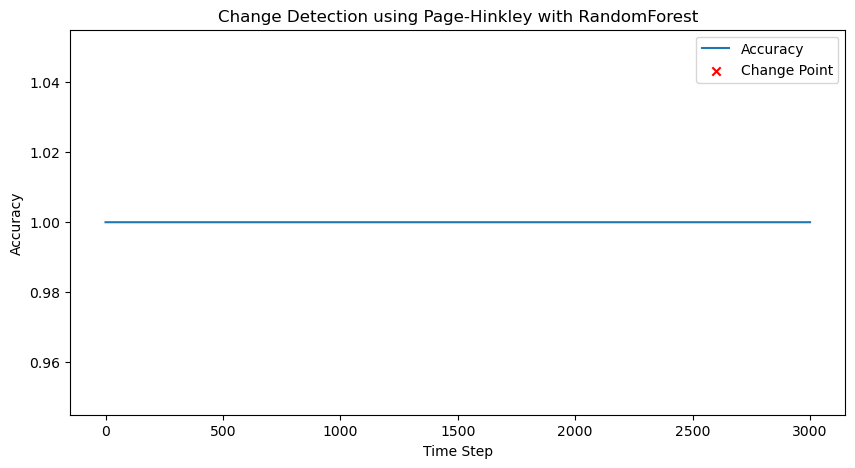

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(len(whole_df)), accuracies, label='Accuracy')
plt.scatter(change_points, [accuracies[i] for i in change_points], color='red', marker='x', label='Change Point')
plt.title('Change Detection using Page-Hinkley with RandomForest')
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()